Grid Search Analysis
===

Compares the results of the grid search per dataset. And spits out the best one...


In [165]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from matplotlib import cm


import json
import codecs
import os
from os import path

In [166]:
basepath = os.path.normpath("C:\Users\hatieke\.ukpsummarizer\scores_cascade")

In [167]:
def parse_dir(dir):
    p = os.path.join(basepath, dir)
    result_jsons = []
    result_files = [f for f in os.listdir(p) if f.startswith("result-") and f.endswith(".json")]
    for f in result_files:
        fn = os.path.join(p, f)
        fsize = os.path.getsize(fn)
        if fsize > 0:
            with open(fn) as fp:
                result_jsons.append(json.load(fp))
    return result_jsons

In [168]:
def parse_single_result_into_dataframe(obj, iteration=11):
    config = obj[u'config_feedbackstore']
    try:
        res = [i for i in obj["result_rougescores"] if i["iteration"] <= iteration][-1]
    except:
        raise BaseException("unknown iteration %s" % (obj["config_run_id"]))
    
    total_accept = sum([1 for i in obj[u'log_feedbacks'] if i["value"] == 'accept' and i["iteration"] < iteration])
    total_reject = sum([1 for i in obj[u'log_feedbacks'] if i["value"] != 'accept' and i["iteration"] < iteration])
    total_feedback = total_accept + total_reject
    
    num_iterations = res["iteration"]
    r1 =  res[u'ROUGE-1 R score']
    r2 =  res[u'ROUGE-2 R score']
    r4 =  res[u'ROUGE-SU* R score']
   
    classtype = config.get(u'type')
    cut_off_threshold = config.get(u'cut_off_threshold')
    iterations_accept = config.get(u'iterations_accept')
    iterations_reject = config.get(u'iterations_reject')
    propagation_abort_threshold = config.get(u'propagation_abort_threshold')
    mass_accept = config.get(u'mass_accept')
    mass_reject = config.get(u'mass_reject')
    window_size = config.get(u'N')
    factor_reject = config.get(u"multiplier_reject")
    factor_accept = config.get(u"multiplier_accept")
    cutoff = config.get(u"cut_off_threshold", config.get("cutoff_threshold"))

    runid = obj.get("config_run_id")
    word2vec = obj.get("config_wordembeddings")
    
    parse_type = obj.get("config_parse_type")
    if parse_type is None or parse_type.lower() is "None".lower():
        parse_type = "ngrams"
        
    oracle_type = obj.get("config_oracle_type", "accept")
      
    ub = obj.get("model_rougescores", {})
    ub_r1 = ub.get("ROUGE-1 R score", -1)
    ub_r2 = ub.get("ROUGE-2 R score", -1)
    ub_r4 = ub.get("ROUGE-SU* R score", -1)
    
    return {
        "accept" : total_accept,
        "reject": total_reject,
        "total_feedback": total_feedback,
        "ref_summary": str([item["name"] for item in obj[u'models']]),
        "cfg": json.dumps(config),
        "num_iterations": num_iterations,
        "r1": r1,
        "r2": r2,
        "r4": r4,
        "classtype": classtype,
        "iterations_accept":iterations_accept,
        "iterations_reject": iterations_reject,
        "propagation_abort_threshold": propagation_abort_threshold,
        "mass_accept" : mass_accept,
        "mass_reject" : mass_reject,
        "window_size": window_size,
        "multiplier_reject": factor_reject,
        "multiplier_accept": factor_accept,
        "cutoff_threshold": cutoff,
        "run_id": runid,
        "ub_r1": ub_r1,
        "ub_r2": ub_r2,
        "ub_r4": ub_r4,
        "phrase_type": parse_type,
        "embeddings": word2vec,
        "size": 100,
        "max_iteration_count": 10
    }


In [169]:
#parse_single_result_into_dataframe(first, iteration=10)

In [173]:
#items = [parse_single_result_into_dataframe(f, iteration=11) for d in dirs for f in parse_dir(d)]
items = [parse_single_result_into_dataframe(f, iteration=11) for f in parse_dir(basepath)]

In [174]:
len(items)

659

In [175]:
#items[0]

In [176]:
df = pd.DataFrame(items)

In [177]:
# convert pojo into string
#df["cfg"] = df.apply(lambda x: json.dumps(x["cfg"]), axis=1)

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 27 columns):
accept                         659 non-null int64
cfg                            659 non-null object
classtype                      659 non-null object
cutoff_threshold               658 non-null float64
embeddings                     659 non-null object
iterations_accept              658 non-null float64
iterations_reject              658 non-null float64
mass_accept                    658 non-null float64
mass_reject                    658 non-null float64
max_iteration_count            659 non-null int64
multiplier_accept              0 non-null object
multiplier_reject              0 non-null object
num_iterations                 659 non-null int64
phrase_type                    659 non-null object
propagation_abort_threshold    658 non-null float64
r1                             659 non-null float64
r2                             659 non-null float64
r4                         

In [179]:
# throw away implausible results
df = df.loc[df.r2 >0].loc[df.r1 > 0].loc[df.r4 >0]

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 0 to 658
Data columns (total 27 columns):
accept                         659 non-null int64
cfg                            659 non-null object
classtype                      659 non-null object
cutoff_threshold               658 non-null float64
embeddings                     659 non-null object
iterations_accept              658 non-null float64
iterations_reject              658 non-null float64
mass_accept                    658 non-null float64
mass_reject                    658 non-null float64
max_iteration_count            659 non-null int64
multiplier_accept              0 non-null object
multiplier_reject              0 non-null object
num_iterations                 659 non-null int64
phrase_type                    659 non-null object
propagation_abort_threshold    658 non-null float64
r1                             659 non-null float64
r2                             659 non-null float64
r4                         

Construction of a dataframe that fits the analysis needs
===

unabhängige Variablen, also Steuervariablen kann ich festlegen, die den Ausgang der Messung beeinflussen (in unbekannter Art). Im Dataframe sind das folgende Spalten:

* classtype
* cutoff_threshold
* iterations_accept
* iterations_reject
* mass_accept
* mass_reject
* multiplier_accept
* multiplier_reject
* propagation_abort_threshold
* ref_summary
* window_size

Und folgende sind die abhängigen Variablen, also die Messvariablen, die quasi die Manifestation der Effekte. 

* accept
* num_iterations
* r1
* r2
* r4
* reject
* total_feedback

Es soll untersucht werden, welche Kombinationen unabhängiger Variablen die besten sind, also die baseline am weitesten übertreffen.

Dazu muss in jeder ref_summary-gruppe der wert der "baseline r2" als extra feld hinzugefügt werden und auch die differenz

Aus Rouge-2 upper bound neue Spalten ableiten: als Delta und als Ratio 
---

In [181]:
# add the delta and ratio of the upper bound r2 as separate columns:
df["delta_r2ub"] = df["ub_r2"] - df["r2"]
df["ratio_r2ub"] = df["r2"] / df["ub_r2"]
df["ratio_r2ub_vs_feedback"] = df["ratio_r2ub"] / df["total_feedback"]

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 0 to 658
Data columns (total 30 columns):
accept                         659 non-null int64
cfg                            659 non-null object
classtype                      659 non-null object
cutoff_threshold               658 non-null float64
embeddings                     659 non-null object
iterations_accept              658 non-null float64
iterations_reject              658 non-null float64
mass_accept                    658 non-null float64
mass_reject                    658 non-null float64
max_iteration_count            659 non-null int64
multiplier_accept              0 non-null object
multiplier_reject              0 non-null object
num_iterations                 659 non-null int64
phrase_type                    659 non-null object
propagation_abort_threshold    658 non-null float64
r1                             659 non-null float64
r2                             659 non-null float64
r4                         

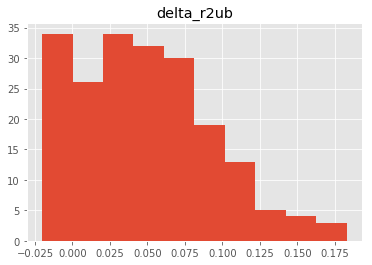

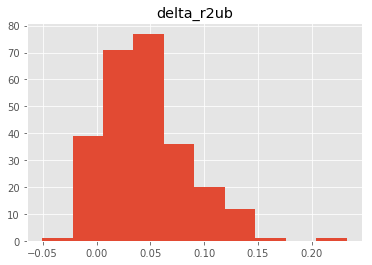

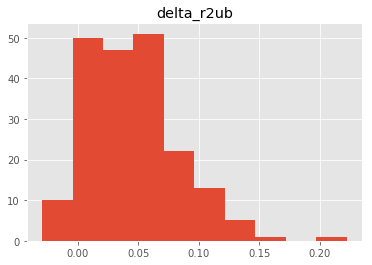

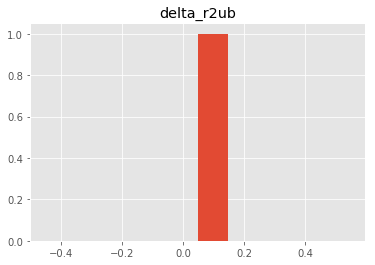

In [188]:
df.groupby("cfg").hist("delta_r2ub")
plt.show()

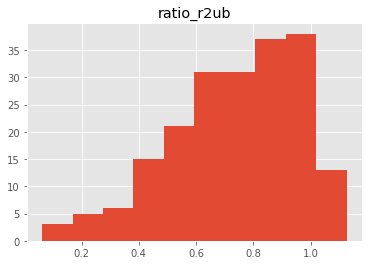

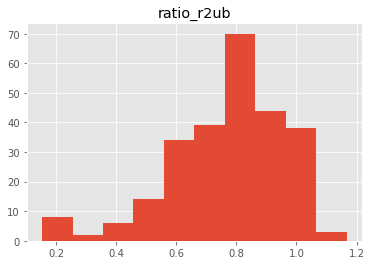

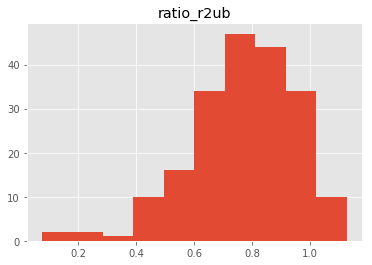

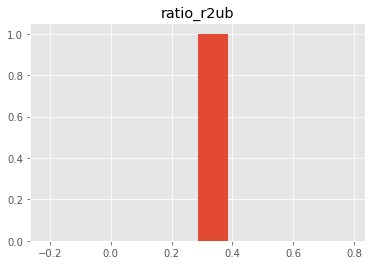

In [189]:
df.groupby("cfg").hist("ratio_r2ub")
plt.show()

statistics comparing against the upper bound (!)
===

The analysis below should give an idea, which independent variables have an influence onto the result. For example, `multiplier_accept` seems to have a positive influence (higher accept multiplier results in higher score). However, A score of 0.6 is not awesome, as it is still below 1.0

The analysis is done per method. I.e. In 4 blocks.


In [183]:
# the variable we want to analyse
dep_var = "ratio_r2ub_vs_feedback"

In [184]:
# the variable we want to analyse
dep_var = "r2"

In [185]:
df.loc[df["num_iterations"]>1]\
    .loc[:, list(set(["cfg", dep_var,"r1","r2","r4"]))]\
    .groupby("cfg")\
    .mean()\
    .sort_values(dep_var, ascending=False)


,r4,r1,r2
cfg,,,
"{""mass_reject"": -4.0, ""iterations_accept"": 1024, ""propagation_abort_threshold"": 0.98, ""mass_accept"": -4.0, ""cut_off_threshold"": 0.6, ""type"": ""WordEmbeddingRandomWalkDiffusionFeedbackGraph"", ""iterations_reject"": 16}",0.153446,0.428520,0.166191
"{""mass_reject"": -4.0, ""iterations_accept"": 1024, ""propagation_abort_threshold"": 0.75, ""mass_accept"": -4.0, ""cut_off_threshold"": 0.6, ""type"": ""WordEmbeddingRandomWalkDiffusionFeedbackGraph"", ""iterations_reject"": 16}",0.150414,0.422440,0.162330
"{""mass_reject"": -4.0, ""iterations_accept"": 1, ""propagation_abort_threshold"": 0.6, ""mass_accept"": -4.0, ""cut_off_threshold"": 0.98, ""type"": ""WordEmbeddingRandomWalkDiffusionFeedbackGraph"", ""iterations_reject"": 1}",0.146857,0.417426,0.161599


Best config, first try
====

best configuration as per agreement between all summaries of same config

we group by configuration, and then use the average ratio_ub2 score as performance measure.

In [186]:
df.sort_values("ratio_r2ub", ascending=False).head(5)

,accept,cfg,classtype,cutoff_threshold,embeddings,iterations_accept,iterations_reject,mass_accept,mass_reject,max_iteration_count,...,run_id,size,total_feedback,ub_r1,ub_r2,ub_r4,window_size,delta_r2ub,ratio_r2ub,ratio_r2ub_vs_feedback
196,34,"{""mass_reject"": -4.0, ""iterations_accept"": 102...",WordEmbeddingRandomWalkDiffusionFeedbackGraph,0.60,glove.6B.300d,1024.0,16.0,-4.0,-4.0,10,...,4a51c1035afc33658e73cb47ef4dc67232555ef7d96bde...,100,511,0.55000,0.30303,0.25985,None,-0.05051,1.166683,0.002283
433,16,"{""mass_reject"": -4.0, ""iterations_accept"": 102...",WordEmbeddingRandomWalkDiffusionFeedbackGraph,0.60,glove.6B.300d,1024.0,16.0,-4.0,-4.0,10,...,ad9a7076afca05911a25391fc2f1dd35bd46a82edd4c96...,100,532,0.43269,0.15534,0.15387,None,-0.01942,1.125016,0.002115
96,19,"{""mass_reject"": -4.0, ""iterations_accept"": 1, ...",WordEmbeddingRandomWalkDiffusionFeedbackGraph,0.98,glove.6B.300d,1.0,1.0,-4.0,-4.0,10,...,288697af61f077007ec6a9c7229546894d3b8e003662ac...,100,573,0.46667,0.15385,0.17398,None,-0.01923,1.124992,0.001963
29,29,"{""mass_reject"": -4.0, ""iterations_accept"": 102...",WordEmbeddingRandomWalkDiffusionFeedbackGraph,0.60,glove.6B.300d,1024.0,16.0,-4.0,-4.0,10,...,086e0430163e7786f155695c63611b013053fbc701a761...,100,469,0.51456,0.28431,0.18431,None,-0.02942,1.103479,0.002353
83,8,"{""mass_reject"": -4.0, ""iterations_accept"": 102...",WordEmbeddingRandomWalkDiffusionFeedbackGraph,0.60,glove.6B.300d,1024.0,16.0,-4.0,-4.0,10,...,205870f401cbb0bba2237dcc34c3a3a97097fdaebe44c5...,100,613,0.36458,0.10526,0.12782,None,-0.01053,1.100038,0.001795
